In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

In [2]:
os.getcwd()

'D:\\projects\\ET_VR_Active\\code'

In [2]:
active_df = pd.read_csv('../data/NEC21_ActiveParticipant.csv',
    parse_dates = ['timestamp_dt'],
    index_col=False,)

In [3]:
active_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316025 entries, 0 to 316024
Data columns (total 72 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   timestamp_dt                      316025 non-null  datetime64[ns]
 1   combinedEye_position_x            316025 non-null  float64       
 2   combinedEye_position_y            316025 non-null  float64       
 3   combinedEye_position_z            316025 non-null  float64       
 4   combinedEye_direction_x           316025 non-null  float64       
 5   combinedEye_direction_y           316025 non-null  float64       
 6   combinedEye_direction_z           316025 non-null  float64       
 7   eye_hit                           316024 non-null  object        
 8   combinedEye_raycastHitLocation_x  316024 non-null  float64       
 9   combinedEye_raycastHitLocation_y  314649 non-null  float64       
 10  combinedEye_raycastHitLocation_z

In [4]:
seated_df = pd.read_csv('../data/NEC21_SeatedParticipant.csv',
    parse_dates = ['timestamp'], index_col=False,)

In [5]:
seated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188240 entries, 0 to 188239
Data columns (total 93 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   timestamp                             188240 non-null  datetime64[ns]
 1   timeStampDataPointStart               188240 non-null  float64       
 2   timeStampDataPointEnd                 188240 non-null  float64       
 3   timeDataPointBeforeGazeRayCasting     188240 non-null  float64       
 4   eyeOpennessLeft                       188240 non-null  float64       
 5   eyeOpennessRight                      188240 non-null  float64       
 6   pupilDiameterMillimetersLeft          188240 non-null  float64       
 7   pupilDiameterMillimetersRight         188240 non-null  float64       
 8   hitObjectNameCombinedEyes             188240 non-null  object        
 9   hitObjectNameLeftEye                  188240 non-null  obje

In [6]:
display(active_df.trial_id.nunique())
display(seated_df.trial_id.nunique())

11

144

In [7]:
def at_mad(angular_vel, th_0=200):
    threshs = []
    thresh_coeff = 3*1.48
    
    # Check input format 
    if len(angular_vel.shape) == 1:
        angular_vel = angular_vel[:,None]
    while True:
        threshs.append(th_0) # store current threshold
        angular_vel = angular_vel[angular_vel < th_0]       
        median = np.median(angular_vel) 
        diff = (angular_vel - median)**2 
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff) 
        th_1 = median + thresh_coeff*med_abs_deviation 
#         print(th_0, th_1)
        if (th_0 - th_1)>1: # make new thresh current thresh and restart in loop             
            th_0 = th_1
        else: # difference between threshs small enough, new thresh becomes saccade thresh 
            saccade_thresh = th_1 
            threshs.append(saccade_thresh)
            break
    return saccade_thresh

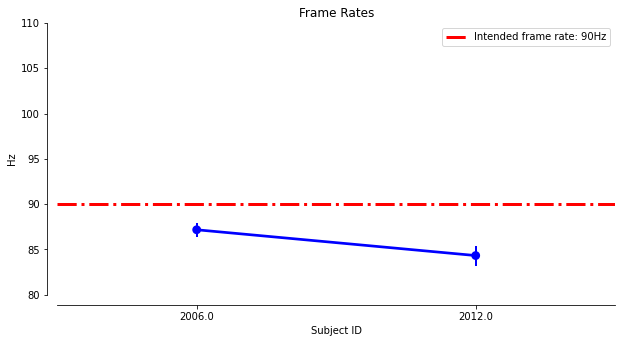

In [8]:
framerate_df = (
    active_df
    .reset_index()
    .drop_duplicates(subset='timestamp_dt')
    .groupby(['subject_id','trial_num'])
    .timestamp_dt
    .apply(lambda x: 
           1/np.mean(
               (
                   x-x.shift(1)
               )
               /np.timedelta64(1, 's')
           )
          )
    .rename('framerate')
    .reset_index()
)

_, ax = plt.subplots(1,1,figsize=(10,5))
sns.pointplot(
    data=framerate_df, 
    x='subject_id', 
    y='framerate', 
    color='b',
    errwidth=2, 
    capsize=0, 
    saturation=0.5, 
    ci='sd'
)
ax.set_ylabel("Hz")
ax.set_ylim(80,110)
ax.set_xlabel("Subject ID")
line = ax.axhline(
    y=90, 
    ls='-.', 
    color='red', 
    lw=3,
    label='Intended frame rate: 90Hz'
)
plt.legend(handles=[line])
plt.title('Frame Rates')
sns.despine(offset=10)

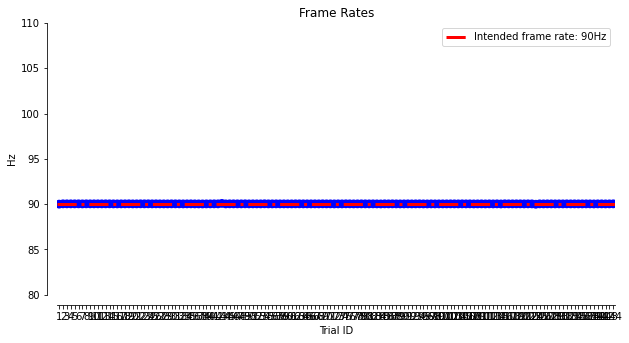

In [9]:
framerate_df = (
    seated_df
    .reset_index()
    .drop_duplicates(subset='timestamp')
    .groupby(['subject_id','trial_id'])
    .timestamp
    .apply(lambda x: 
           1/np.mean(
               (
                   x-x.shift(1)
               )
               /np.timedelta64(1, 's')
           )
          ) 
    .rename('framerate')
    .reset_index()
)

_, ax = plt.subplots(1,1,figsize=(10,5))
sns.pointplot(
    data=framerate_df, 
    x='trial_id', 
    y='framerate', 
    color='b',
    errwidth=2, 
    capsize=0, 
    saturation=0.5, 
    ci='sd'
)
ax.set_ylabel("Hz")
ax.set_ylim(80,110)
ax.set_xlabel("Trial ID")
line = ax.axhline(
    y=90, 
    ls='-.', 
    color='red', 
    lw=3,
    label='Intended frame rate: 90Hz'
)
plt.legend(handles=[line])
plt.title('Frame Rates')
sns.despine(offset=10)

In [12]:
active_df = active_df.query('subject_id == 2006')


In [13]:
active_df['eye_theta_h'] = (
    np.arctan2(
        active_df['combinedEye_direction_x'], 
        active_df['combinedEye_direction_z']
    )
)
active_df['eye_theta_v'] = (
    np.arctan2(
        active_df['combinedEye_direction_y'],
        active_df['combinedEye_direction_z']
    )
)

active_df['head_theta_h'] = (
    np.arctan2(
        active_df['nosePointer_direction_x'], 
        active_df['nosePointer_direction_z']
    )
)
active_df['head_theta_v'] = (
    np.arctan2(
        active_df['nosePointer_direction_y'],
        active_df['nosePointer_direction_z']
    )
)

active_df['eye_vel_h'] = (
    active_df
    .groupby(['subject_id','trial_num'])
    .eye_theta_h
    .apply(lambda x: x.diff())
)/(
    active_df
    .groupby(['subject_id','trial_num'])
    .timestamp_dt
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)


active_df['eye_vel_h'] = active_df['eye_vel_h']*180/np.pi

active_df['eye_vel_v'] = (
    active_df
    .groupby(['subject_id','trial_num'])
    .eye_theta_v
    .apply(lambda x: x.diff())
)/(
    active_df
    .groupby(['subject_id','trial_num'])
    .timestamp_dt
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)

active_df['eye_vel_v'] = active_df['eye_vel_v']*180/np.pi


active_df['head_vel_h'] = (
    active_df
    .groupby(['subject_id','trial_num'])
    .head_theta_h
    .apply(lambda x: x.diff())
)/(
    active_df
    .groupby(['subject_id','trial_num'])
    .timestamp_dt
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)


active_df['head_vel_h'] = active_df['head_vel_h']*180/np.pi

active_df['head_vel_v'] = (
    active_df
    .groupby(['subject_id','trial_num'])
    .head_theta_v
    .apply(lambda x: x.diff())
)/(
    active_df
    .groupby(['subject_id','trial_num'])
    .timestamp_dt
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)

active_df['head_vel_v'] = active_df['head_vel_v']*180/np.pi

In [14]:
active_df['eye_angular_vel'] =np.sqrt(active_df.eye_vel_h**2 + active_df.eye_vel_v**2)
active_df['head_angular_vel'] =np.sqrt(active_df.head_vel_h**2 + active_df.head_vel_v**2)

In [15]:
seated_df = seated_df.sort_values('timestamp')
seated_df['eye_theta_h'] = np.arctan2(
    seated_df['eyeDirectionCombinedWorld.z'], # was x in orig code
    seated_df['eyeDirectionCombinedWorld.x']
) # was z 
seated_df['eye_theta_v'] = np.arctan2(
    seated_df['eyeDirectionCombinedWorld.y'], # was y 
    seated_df['eyeDirectionCombinedWorld.x']
) # was z 

seated_df['head_theta_h'] = np.arctan2(
    seated_df['hmdDirectionForward.z'], # was x in orig code
    seated_df['hmdDirectionForward.x']
) # was z
seated_df['head_theta_v'] = np.arctan2(
    seated_df['hmdDirectionForward.y'], # was y
    seated_df['hmdDirectionForward.x']
) # was z

seated_df['head_theta_h'] = (
    np.arctan2(
        seated_df['hmdDirectionForward.z'], 
        seated_df['hmdDirectionForward.x']
    )
)
seated_df['head_theta_v'] = (
    np.arctan2(
        seated_df['hmdDirectionForward.y'],
        seated_df['hmdDirectionForward.x']
    )
)

seated_df['eye_vel_h'] = (
    seated_df
    .groupby(['subject_id','trial_id'])
    .eye_theta_h
    .apply(lambda x: x.diff())
)/(
    seated_df
    .groupby(['subject_id','trial_id'])
    .timestamp
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)


seated_df['eye_vel_h'] = seated_df['eye_vel_h']*180/np.pi

seated_df['eye_vel_v'] = (
    seated_df
    .groupby(['subject_id','trial_id'])
    .eye_theta_v
    .apply(lambda x: x.diff())
)/(
    seated_df
    .groupby(['subject_id','trial_id'])
    .timestamp
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)

seated_df['eye_vel_v'] = seated_df['eye_vel_v']*180/np.pi


seated_df['head_vel_h'] = (
    seated_df
    .groupby(['subject_id','trial_id'])
    .head_theta_h
    .apply(lambda x: x.diff())
)/(
    seated_df
    .groupby(['subject_id','trial_id'])
    .timestamp
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)


seated_df['head_vel_h'] = seated_df['head_vel_h']*180/np.pi

seated_df['head_vel_v'] = (
    seated_df
    .groupby(['subject_id','trial_id'])
    .head_theta_v
    .apply(lambda x: x.diff())
)/(
    seated_df
    .groupby(['subject_id','trial_id'])
    .timestamp
    .apply(lambda x: x.diff()/np.timedelta64(1, 's'))
)

seated_df['head_vel_v'] = seated_df['head_vel_v']*180/np.pi

In [16]:
seated_df['eye_angular_vel'] =np.sqrt(seated_df.eye_vel_h**2 + seated_df.eye_vel_v**2)
seated_df['head_angular_vel'] =np.sqrt(seated_df.head_vel_h**2 + seated_df.head_vel_v**2)

In [17]:
active_df['is_fixation'] = (
    active_df
    .groupby(['subject_id', 'trial_num'], as_index=False)
    .eye_angular_vel
    .transform(lambda x: x < at_mad(x))
)

active_df['velocity_threshold'] = (
    active_df
    .groupby(['subject_id', 'trial_num'], as_index=False)
    .eye_angular_vel
    .transform(lambda x: at_mad(x))
)

In [18]:
active_df['time_since_start'] = (
    active_df
    .set_index('timestamp_dt')
    .groupby(['subject_id', 'trial_num'], as_index=False)
    .transform(lambda x: (x.index - x.index[0])/np.timedelta64(1,'s'))    
    .reset_index()
    .is_fixation
)

In [19]:
seated_df['is_fixation'] = (
    seated_df
    .groupby(['subject_id', 'trial_id'], as_index=False)
    .eye_angular_vel
    .transform(lambda x: x < at_mad(x))
)

seated_df['velocity_threshold'] = (
    seated_df
    .groupby(['subject_id', 'trial_id'], as_index=False)
    .eye_angular_vel
    .transform(lambda x: at_mad(x))
)

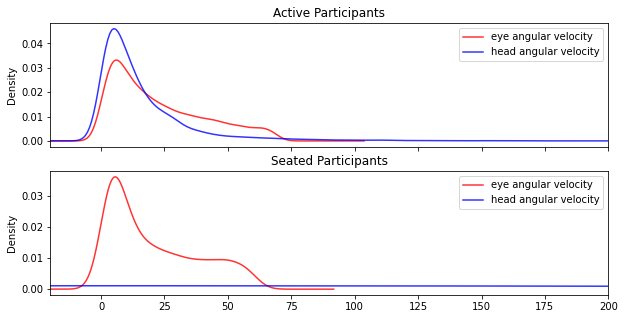

In [20]:
_, ax = plt.subplots(2,1,figsize=(10,5), sharex=True, sharey=False)
active_df.query('trial_num==2 and is_fixation==1').eye_angular_vel.plot(kind='kde', color='r',alpha=0.8, label='eye angular velocity', ax=ax[0])
active_df.query('trial_num==2 and is_fixation==1').head_angular_vel.plot(kind='kde', color='b',alpha=0.8, label='head angular velocity', ax=ax[0])

seated_df.query('trial_id==30 and is_fixation==1').eye_angular_vel.plot(kind='kde', color='r',alpha=0.8, label='eye angular velocity', ax=ax[1])
seated_df.query('trial_id==30 and is_fixation==1').head_angular_vel.plot(kind='kde', color='b',alpha=0.8, label='head angular velocity', ax=ax[1])

ax[0].legend()
ax[0].set(
    title = 'Active Participants',
    xlim=(-20,200)
)
ax[1].legend()
ax[1].set(
    title='Seated Participants',
    xlim=(-20,200)
);

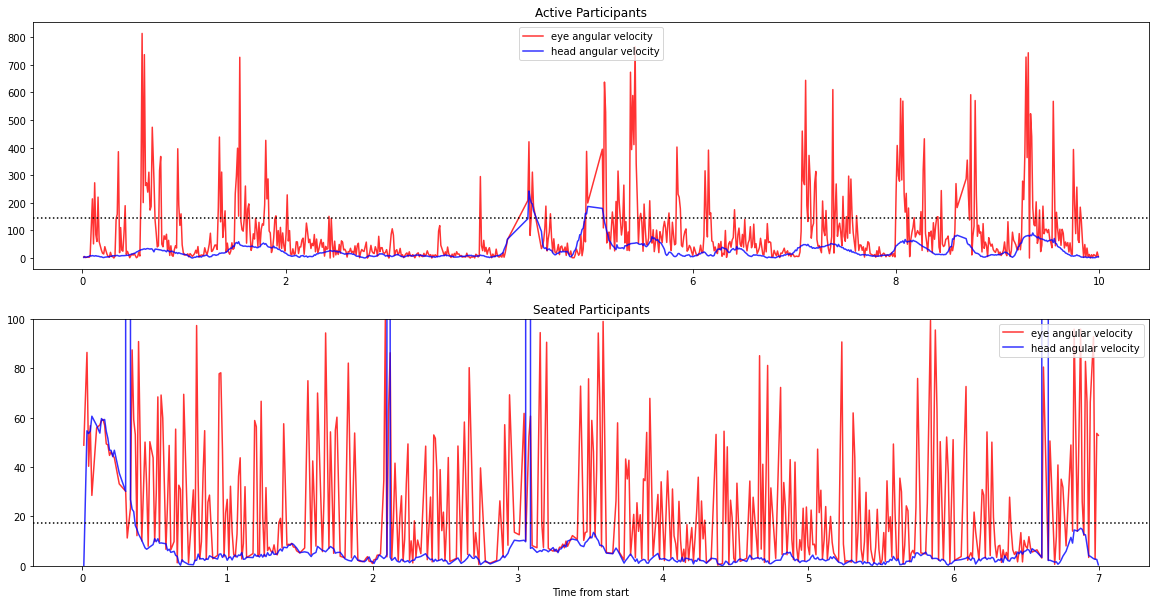

In [21]:
_, ax = plt.subplots(2,1,figsize=(20,10), sharex=False, sharey=False)
(
    active_df
    .set_index('timestamp_dt')
    .query('trial_num==10 and time_since_start<10')
    .plot(kind='line', x='time_since_start', y='eye_angular_vel',color='r',alpha=0.8,
          label='eye angular velocity', ax=ax[0])
)
(
    active_df
    .set_index('timestamp_dt')
    .query('trial_num==10 and time_since_start<10')
    .plot(kind='line',x='time_since_start', y='head_angular_vel', color='b',alpha=0.8, label='head angular velocity', ax=ax[0])
)
ax[0].axhline(active_df.query('trial_num==10').velocity_threshold.values[0], ls=':', color='k')
(
    seated_df
    .set_index('timestamp')
    .query('trial_id==3 and time_since_start < 7 and eye_angular_vel <100')
    .plot(kind='line', x='time_since_start', y='eye_angular_vel', color='r',
          alpha=0.8, label='eye angular velocity', ax=ax[1])
)
(
    seated_df
    .set_index('timestamp')
    .query('trial_id==3 and time_since_start < 7 and eye_angular_vel <100')
    .plot(kind='line', x='time_since_start', y='head_angular_vel', color='b',
          alpha=0.8, label='head angular velocity', ax=ax[1])
)
ax[1].axhline(seated_df.query('trial_id==3').velocity_threshold.values[0], ls=':', color='k')
ax[0].legend()
ax[0].set(
    title='Active Participants',
#     xticklabels=[],
    xlabel='',
#     xlim=(-20,200)
)
ax[1].legend()
ax[1].set(
    title='Seated Participants',
    xlabel='Time from start',
    ylim=(0,100)
);

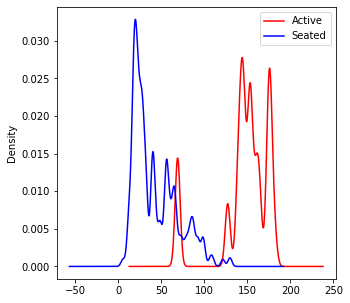

In [23]:
_, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=False)

(
    active_df
    .velocity_threshold
    .plot(kind='kde', ax=ax, color='r', label='Active')
)
(
    seated_df
    .velocity_threshold
    .plot(kind='kde', ax=ax, color='b', label='Seated')
)
ax.legend()